# Manifold MCMC methods for diffusions: *FitzHugh-Nagumo* model example

This [Jupyter notebook](https://jupyter.org/) accompanies the paper [*Manifold MCMC methods for Bayesian inference in a wide class of diffusion models*](https://arxiv.org/abs/1912.02982), providing a complete runnable example of applying the method described in the paper to perform inference in an example hypoelliptic diffusion model.

## Setup

We first check if the notebook is being run on [Binder](https://mybinder.org/) or [Google Colab](https://colab.research.google.com/) and if so install the `sde` package and the other dependencies using `pip`.

In [1]:
import os
ON_BINDER = 'BINDER_SERVICE_HOST' in os.environ

try:
    import google.colab
    ON_COLAB = True
except:
    ON_COLAB = False

if ON_COLAB:
    !pip install git+https://github.com/thiery-lab/manifold-mcmc-for-diffusions.git#egg=sde[notebook]


We now import the modules we will use to simulate from the model and perform inference

In [2]:
import mici
import sde.mici_extensions as mici_extensions
import symnum
import symnum.diffops.symbolic as diffops
import symnum.numpy as snp
import numpy as onp
import jax
from jax import lax, config, numpy as jnp
import matplotlib.pyplot as plt
import arviz
import corner

config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')


We also set a dictionary of style parameters to use with Matplotlib plots

In [3]:
plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}


## Diffusion model

As an illustration we will consider the hypoelliptic diffusion defined by the system of *stochastic differential equations* (SDEs)

$$
  \underbrace{\begin{bmatrix} \mathrm{d} \mathsf{x}_0(\tau) \\ \mathrm{d} \mathsf{x}_1(\tau) \end{bmatrix}}_{\mathrm{d}\mathsf{x}(\tau)} = 
  \underbrace{\begin{bmatrix}
    \frac{1}{\epsilon} (\mathsf{x}_0(\tau) - \mathsf{x}_0(\tau)^3 - \mathsf{x}_1(\tau)) \\
    \gamma \mathsf{x}_0(\tau) - \mathsf{x}_1(\tau) + \beta
  \end{bmatrix}}_{a(\mathsf{x}(\tau),\mathsf{z})} \mathrm{d} \tau + 
  \underbrace{\begin{bmatrix} 0 \\ \sigma \end{bmatrix}}_{B(\mathsf{x}(\tau),\mathsf{z})} \mathrm{d} \mathsf{w}(\tau)
$$
with $\mathsf{x}$ the $\mathcal{X} = \mathbb{R}^2$-valued diffusion process of interest, $\mathsf{w}$ a univariate Wiener process and $\mathsf{z} = [\sigma;\epsilon;\gamma;\beta] \in \mathcal{Z} =\mathbb{R}_{>0} \times \mathbb{R}_{>0} \times \mathbb{R} \times \mathbb{R}$ the model parameters. 

This SDE system corresponds to a stochastic variant of the [Fitzhugh-Nagumo model](http://www.scholarpedia.org/article/FitzHugh-Nagumo_model), a simplified description of actional potential generation within a neuronal axon.

We will use [SymNum](https://github.com/matt-graham/symnum) to symbolically define the drift $a$ and diffusion coefficient $B$ functions for the model in terms of the current state $\mathsf{x}$ and parameters $\mathsf{z} = [\sigma;\epsilon;\gamma;\beta]$. This will later allow us to automatically construct a function to numerical integrate the SDE system.

In [4]:
dim_x = 2
dim_w = 1
dim_z = 4

def drift_func(x, z):
    σ, ε, γ, β = z
    return snp.array([(x[0] - x[0]**3 - x[1]) / ε, γ * x[0] - x[1] + β])

def diff_coeff(x, z):
    σ, ε, γ, β = z
    return snp.array([[0], [σ]])


## Time discretisation

As in general exact simulation of the diffusion models of interest will be intractable, we define an approximate discrete time model based on numerical integration of the SDEs. Various numerical schemes for integrating SDE systems are available with varying convergence properties and implementational complexity - see for example [*Numerical Solutions of Stochastic Differential Equations* (Kloden and Platen, 1992)](https://books.google.com.sg/books/about/Numerical_Solution_of_Stochastic_Differe.html?id=7bkZAQAAIAAJ&source=kp_book_description&redir_esc=y) for an in-depth survey.

The simplest and most common scheme is the *Euler-Maruyama* method (corresponding to a strong-order 0.5 Taylor approximation), which for a small time step $\delta > 0$ can be defined by a *forward operator* $f_{\delta} : \mathcal{Z} \times \mathcal{X} \times \mathcal{V} \to \mathcal{X}$

$$
  f_\delta(z, x, v) = 
  x + \delta {a}(x, z) + 
  \delta^\frac{1}{2} B(x,z) v
$$

where $v \in \mathcal{V}$ is a vector of independent standard normal random variates of dimension equal to that of the Wiener process (here one).

The corresponding single step update can be defined using SymNum as:

In [5]:
def euler_maruyama_step(z, x, v, δ):
    return x + δ * drift_func(x, z) + δ**0.5 * diff_coeff(x, z) @ v

More accurate approximations can be derived by using higher-order terms from the stochastic Taylor expansion of the SDE system. For example for a SDE model with *additive noise*, i.e. a diffusion coefficient $B$ which is independent of the state $B(x, z) = B(z)$, a *strong order 1.5 Taylor scheme* can be defined by the forward operator

$$
  f_\delta(z, x, [v_1; v_2]) = 
  x + \delta a(x, z) + 
  \frac{\delta^2}{2} \partial_0 a(x,z) a(x,z) + 
  \frac{\delta^2}{4}[(\mathrm{tr}(\partial^2_1 a_i(x, z) B(z) B(z)^{\rm T}))_{i=0}^{\mathtt{X}-1}] +
  \delta^{\frac{1}{2}} B(z) v_0 +
  \frac{\delta^{\frac{3}{2}}}{2} \partial_1 a(x,z) B(z) (v_0 + v_1 / \sqrt{3})
$$

with both $v_1$ and $v_2$ having the dimension of the Wiener process and so the vector $v = [v_0; v_1]$  twice the dimension of the Wiener process (therefore of dimension 2 here). This can be implemented using SymNum as follows

In [6]:
def strong_order_1p5_step(z, x, v, δ):
    a = drift_func(x, z)
    da_dx = diffops.jacobian(drift_func)(x, z)
    B = diff_coeff(x, z)
    dim_noise = B.shape[1]
    d2a_dx2_BB = diffops.matrix_hessian_product(drift_func)(x, z)(B @ B.T)
    v_1, v_2 = v[:dim_noise], v[dim_noise:]
    return (
        x + δ * a + (δ**2 / 2) * da_dx @ a + (δ**2 / 4) * d2a_dx2_BB + 
        δ**0.5 * B @ v_1 + (δ**1.5 / 2) * da_dx @ B @ (v_1 + v_2 / snp.sqrt(3)))


We can use these symbolically defined single step updates to define corresponding numerical functions which take NumPy arrays as inputs using SymNum's `numpify`_func function. As well as the function to be transformed, the `numpify_func` function requires the shape (dimensions) of all arguments to be specified. It also optionally allows specifying the module to use for the NumPy API calls with here we using the `jax.numpy` module from [JAX](https://github.com/google/jax) as this will allow us to later automatically construct efficient derivative functions for inference. Below we define a forward operator function using the strong order 1.5 step however we can instead use the Euler-Maruyma discretisation simply by setting the `use_euler_maruyama` flag to `True`.

In [7]:
use_euler_maruyama = False
if use_euler_maruyama:
    forward_func = euler_maruyama_step
    dim_v = dim_w
else:
    forward_func = strong_order_1p5_step
    dim_v = 2 * dim_w
forward_func = symnum.numpify_func(
    forward_func, (dim_z,), (dim_x,), (dim_v,), None, numpy_module=jnp
)


Given a forward operator we can generate (approximate) samples of the state process at a series of discrete times. Here we assume that we use a fixed time increment $\delta > 0$ for all integrator steps and denote $\mathsf{x}_{\texttt{s}}$ as the approximation to $\mathsf{x}(\mathtt{s}\delta)$.

## Observation model

As in the paper we assume the simple case that the diffusion process is discretely observed at $\texttt{T}$ equally spaced times $\tau_\texttt{t} = \texttt{t}\Delta~~\forall \texttt{t}\in 1{:}\texttt{T}$. We use a fixed number of steps $\texttt{S}$ per interobservation interval with $\delta = \frac{\Delta}{\texttt{S}}$ so that the state at the $\texttt{t}$<sup>th</sup> observation time is $\mathsf{x}_{\texttt{St}}$ and the whole sequence of states to be simulated is $\mathsf{x}_{1{:}\mathtt{ST}}$.

We assume the $\mathtt{Y} = 1$ dimensional observations $\mathsf{y}_{1{:}\mathtt{T}}$ correspond to direct observation of the first state component i.e. $\mathsf{y}_\texttt{t} = h_\mathtt{t}(\mathsf{x}) = \mathsf{x}_0 ~~\forall \mathtt{t} \in 1{:}\mathtt{T}$.

In [8]:
def obs_func(x_seq):
    return x_seq[..., 0:1]


## Generative model

As described in the paper we use a non-centered parameterisation of the generative model for the parameters $\mathsf{z}$, time-discretised diffusion $\mathsf{x}_{0{:}\mathtt{ST}}$ and observations $\mathsf{y}_{1{:}\mathtt{T}}$

We use priors $\mathsf{x}_{0} \sim \mathcal{N}([-0.5;-0.5], \mathbb{I}_2)$, $\log{\sigma} \sim \mathcal{N}\left(-1, 0.5^2\right)$, $\log{\epsilon} \sim \mathcal{N}\left(-2, 0.5^2\right)$, ${\gamma} \sim \mathcal{N}\left(1, 0.5^2\right)$ and ${\beta} \sim \mathcal{N}\left(1, 0.5^2\right)$ which were roughly tuned so that with high probability state sequences $\mathsf{x}_{1{:}\mathtt{ST}}$ generated from the prior exhibited stable spiking dynamics and such that $\sigma$ and $\epsilon$ obey their positivity constraints. 

We reparameterise the parameters $\mathsf{z}$ and initial state $\mathsf{x}_0$ in terms of vectors of standard normal variates, respectively $\mathsf{u}$ and $\mathsf{v}_0$, with the parameter and initial state generator functions then set to $g_{\mathsf{z}}(u) = [\exp(0.5 u_0 -1); \exp(0.5 u_1 - 2); 0.5 u_2 + 1; 0.5 u_3 + 1]$ and $g_{\mathsf{x}_0}(v_0, z) = [v_{0,0} -0.5; v_{0,1} - 0.5]$ with input distributions $\tilde{\mu} = \mathcal{N}(0,\mathbb{I}_4)$ and $\tilde{\nu} = \mathcal{N}(0,\mathbb{I}_2)$. We can implement these generator functions in Python using JAX NumPy API functions (to allow us to later algorithmically differentiate through the generative model) as follows. 

In [9]:
def generate_z(u):
    """Generate parameters from prior given an standard normal vector."""
    return jnp.array([
        jnp.exp(0.5 * u[0] - 1),  # σ
        jnp.exp(0.5 * u[1] - 2),  # ϵ
        0.5 * u[2] + 1,  # γ
        0.5 * u[3] + 1,  # β
    ])

def generate_x_0(z, v_0):
    """Generate an initial state from prior given a standard normal vector."""
    return jnp.array([-0.5, -0.5]) + v_0


The overall joint generative model for $\mathsf{z}$, $\mathsf{x}_{0{:}\mathtt{ST}}$ and $\mathsf{y}_{1{:}\mathtt{T}}$ in terms of the independent and standard normal variates $\mathsf{u}$ and $\mathsf{v}_{0{:}\mathtt{ST}}$ can then be summarised

$$
\begin{aligned}
  \mathsf{u} &\sim \mathcal{N}(0, \mathbb{I}_4) \\
  \mathsf{v}_\texttt{s} &\sim \mathcal{N}(0, \mathbb{I}_2) \quad &\forall \mathtt{s} \in 0{:}\mathtt{ST}\\
  \mathsf{z} &= g_{\mathsf{z}}(\mathsf{u})\\
  \mathsf{x}_0 &= g_{\mathsf{x}_0}(\mathsf{v}_0, \mathsf{z}) \\
  \mathsf{x}_{\mathtt{s}+1} &= f_{\delta}(\mathsf{z}, \mathsf{x}_{\mathtt{s}}, \mathsf{v}_{\mathtt{s}})
  \quad &\forall \mathtt{s} \in 1{:}\mathtt{ST}\\
  \mathsf{y}_{\mathtt{t}} &= h_{\mathtt{t}}(\mathsf{x}_{\mathtt{St}})
  \quad &\forall \mathtt{t} \in 1{:}\mathtt{T}
\end{aligned}
$$

We collect all of the latent variables in to a $6 + 2\texttt{ST}$ dimensional flat vector $\mathsf{q} := [\mathsf{u}; \mathsf{v}_{0{:}\mathtt{ST}}]$, with all components of $\mathsf{q}$ a priori independent and standard normal distributed, i.e. $\mathsf{q} \sim \mathcal{N}(0, \mathbb{I}_{6+2\mathtt{ST}})$.

A function to sample from the overall generative model given a latent input vector $\mathsf{q}$ can be implemented using the `generate_z`, `generate_x_0` and `forward_func` functions and the JAX [`scan`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) operator (a differentiable loop / iterator construct) as follows

In [10]:
def generate_from_model(q, δ, dim_x, dim_z, dim_v, num_steps_per_obs):
    """Generate parameters and state + obs. sequences from model given q."""
    u, v_0, v_r = jnp.split(q, (dim_z, dim_z + dim_x))
    z = generate_z(u)
    x_0 = generate_x_0(z, v_0)
    v_seq = jnp.reshape(v_r, (-1, dim_v))

    # Define integrator step function to scan:
    #   first argument is carried-forward state,
    #   second argument is input from scanned sequence.
    def step_func(x, v):
        x_n = forward_func(z, x, v, δ)
        # Scan expects to return a tuple with the first element the carry-forward state
        # and second element a slice of the output sequence (here also the state)
        return x_n, x_n

    # Scan step_func over the noise sequence v_seq initialising carry-forward with x_init
    _, x_seq = lax.scan(step_func, x_0, v_seq)
    y_seq = obs_func(x_seq[num_steps_per_obs - 1 :: num_steps_per_obs])
    return x_seq, y_seq, z, x_0


## Generate simulated observed data

In order to allow us to illustrate performing inference with the model, we first generate simulated observed data from the model itself, with the aim of then inferring the posterior distribution on the 'unknown' latent state given the simulated observations. We use $\mathtt{T} = 100$ observation times with interobservation interval $\Delta = 0.5$ and $\mathtt{S} = 25$ integrator steps per interobservation interval ($\delta = 0.02$) giving us an overall latent dimension of $\mathtt{Q} = 5006$ (we instead use $\mathtt{T} = 20$ and $\mathtt{S} = 10$ if running on Binder to reduce the CPU demand with then $\mathtt{Q} = 406$).

In [11]:
obs_interval = 0.5
if not ON_BINDER:
    num_obs = 100
    num_steps_per_obs = 25
else:
    num_obs = 20
    num_steps_per_obs = 10
num_steps = num_obs * num_steps_per_obs
dim_q = dim_z + dim_x + num_obs * num_steps_per_obs * dim_v
δ = obs_interval / num_steps_per_obs


We seed a NumPy `RandomState` pseudo-random number generator object and use it to generate a latent input vector $\mathsf{q}$ from its standard normal prior.

In [12]:
seed = 20200710
rng = onp.random.RandomState(seed)
q_ref = rng.standard_normal(size=dim_q)


Using the previously defined `generate_from_model` function we now generate simulated state and observation sequences, parameters and the initial state from the model given the just generated latent input vector.

In [13]:
x_seq_ref, y_seq_ref, z_ref, x_0_ref = generate_from_model(
    q_ref, δ, dim_x, dim_z, dim_v, num_steps_per_obs
)

We can visualise the simulated state and observation sequences using Matplotlib. Below the blue and orange lines show the time courses of respectively the $\mathsf{x}_0$ and $\mathsf{x}_1$ state components, with the blue crosses indicating the simulated discrete time observations of the $\mathsf{x}_0$ component.

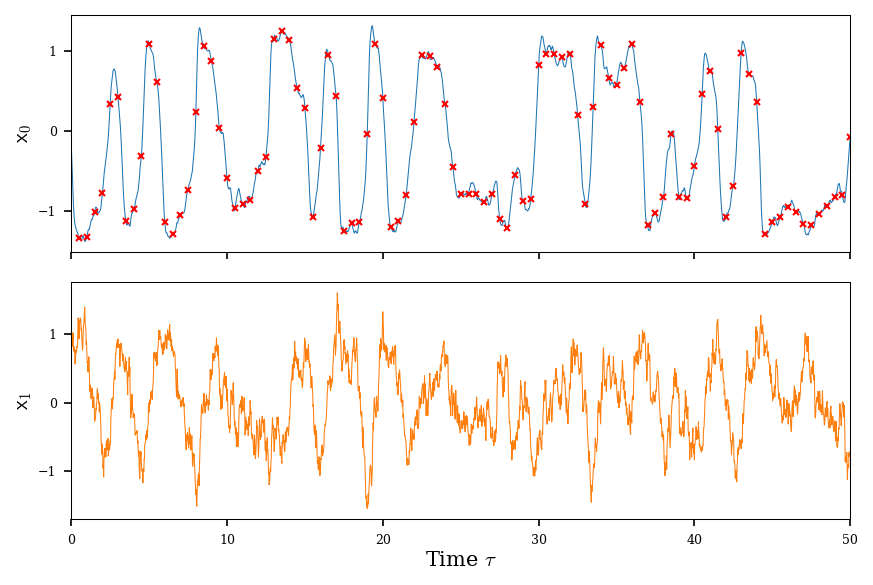

In [14]:
with plt.style.context(plot_style):
    fig, axes = plt.subplots(2, sharex=True, figsize=(6, 4), dpi=150)
    t_seq = (1 + onp.arange(num_steps)) * (num_obs) * obs_interval / num_steps
    obs_indices = (1 + onp.arange(num_obs)) * num_steps_per_obs - 1
    axes[0].plot(t_seq, x_seq_ref[:, 0], lw=0.5, color="C0")
    axes[1].plot(t_seq, x_seq_ref[:, 1], lw=0.5, color="C1")
    axes[0].plot(t_seq[obs_indices], y_seq_ref[:, 0], "x", ms=3, color="red")
    axes[0].set_ylabel(r"$\mathsf{x}_{0}$")
    axes[1].set_ylabel(r"$\mathsf{x}_{1}$")
    for ax in axes:
        ax.set_xlim(0, num_obs * obs_interval)
    _ = axes[1].set_xlabel("Time $\\tau$")
    fig.tight_layout()


## Manifold Markov chain Monte Carlo approximate inference using *Mici*

[![Mici logo](https://matt-graham.github.io/mici/images/mici-logo-rectangular.svg)](https://matt-graham.github.io/mici/)

To perform inference in the model given our simulated observed data, we use the manifold MCMC method implementations in the package [*Mici*](https://matt-graham.github.io/mici/). 

The key model-specific object required for inference in Mici is a *Hamiltonian system* instance. The Hamiltonian system encapsulates the various components of the Hamiltonian function for which the associated Hamiltonian dynamics are used as a proposal generating mechanism in a MCMC method. Mici includes various generic Hamiltonian system classes in the `mici.systems` module corresponding to common cases such as (unconstrained) systems with Euclidean and Riemannian metrics and constrained Hamiltonian systems with a constraint function with dense Jacobian. Here we instead use a custom system class defined in the `sde.mici_extensions` module which defines a constrained Hamiltonian system corresponding to a generative model for a diffusion as defined above (see Sections 3 and 4 in the paper). In particular our implementation exploits the sparsity induced in the Jacobian of the constraint function by artificially conditioning on the full state at a set of time points when sampling, as described in Section 5 in the paper. To construct an instance of this system class we pass in the variables defining the model dimensions defined earlier, the simulated observation sequence `y_seq_ref`, the generated `forward_func` implementing the strong-order 1.5 numerical integration scheme for the model, the `generate_x_0` and `generate_z` generator functions and `obs_func` observation function. This class expects the passed functions to be defined using JAX primitives such as via calls to functions in the `jax.numpy` module, so that it can use JAX's automatic differentiation primitives to automatically construct the required derivative functions.

In [15]:
num_obs_per_subseq = 5  # Number of obs in each fully conditioned subsequence
system = mici_extensions.ConditionedDiffusionConstrainedSystem(
    obs_interval,
    num_steps_per_obs,
    num_obs_per_subseq,
    y_seq_ref,
    dim_z,
    dim_x,
    dim_v,
    forward_func,
    generate_x_0,
    generate_z,
    obs_func,
    use_gaussian_splitting=True,
)


As well as the Hamiltonian system we also need to define an associated (symplectic) integrator, to numerically simulate the associated Hamiltonian dynamics. Here we use the `mici.integrators.ConstrainedLeapfrogIntegrator` class, which corresponds to the constrained symplectic integrator described in Algorithm 1 in the paper (here we use the Gaussian specific Hamiltonian splitting described in Section 4.3.1 in the paper). We specify the tolerances on both the norm of the constraint equation `constraint_tol` and the successive change in the position `position_tol` for the Newton iteration used to solve the non-linear system of constraint equations, and also set a maximum number of iterations `max_iters`. The tolerances for the reversibility check is set to `2 * position_tol` (motivated by the intuition that each of the forward and backward retraction / projection steps are solved to a position tolerance of `position_tol`, so if the errors accumulate linearly the overall error in a reversible step should be less than `2 * position_tol`).

In [16]:
max_iters = 50  # Maximum number of quasi-Newton iterations in retraction solver
constraint_tol = 1e-9  # Convergence tolerance in constraint (observation) space
position_tol = 1e-8  # Convergence tolerance in position (latent) space
integrator = mici.integrators.ConstrainedLeapfrogIntegrator(
    system,
    projection_solver=mici_extensions.jitted_solve_projection_onto_manifold_newton,
    reverse_check_tol=2 * position_tol,
    projection_solver_kwargs=dict(
        constraint_tol=constraint_tol, position_tol=position_tol, max_iters=max_iters
    ),
)

The final key object required for inference in Mici, is a MCMC sampler class instance. Here we use a MCMC method which sequentially applies three Markov transition kernels leaving the (extended) target distribution invariant on each iteration. 

The first is a transition in which the momentum is independently resampled from its conditional distribution given the position (as described in Section 4.2 in the paper), as implemented by the `mici.transitions.IndependentMomentumTransition` class. We could instead for example use an instance of `mici.transitions.CorrelatedMomentumTransition` which would give to partial / correlated momentum resampling.

The second transition is the main Hamiltonian-dynamics driven transition which simulates the Hamiltonian dynamics associated with the passed `system` object using the `integrator` object to generate proposed moves. Here we use `mici.transitions.MultinomialDynamicIntegrationTransition`, a dynamic integration time Hamiltonian Monte Carlo transition with multonimial sampling from the trajectory, analagous to the sampling algorithm used in the popular probabilistic programming framework [Stan](https://mc-stan.org/) and as described in Appendix A in the article [*A conceptual introduction to Hamiltonian Monte Carlo* (Betancourt, 2017)](https://arxiv.org/abs/1701.02434).

The previous transition simulates the Hamiltonian dynamics for the *conditioned* diffusion system, i.e. full conditioning on a subset set of the states at the observation times. Therefore the third and final transition deterministically updates the set of observation time indices that are conditioned on in the Hamiltonian-dynamics integration based transition, here switching between two sets of observation time indices (partitions of the observation sequence) as descibed in Section 5 in the paper.

In [17]:
sampler = mici.samplers.MarkovChainMonteCarloMethod(
    rng,
    transitions={
        "momentum": mici.transitions.IndependentMomentumTransition(system),
        "integration": mici.transitions.MultinomialDynamicIntegrationTransition(
            system, integrator
        ),
        "switch_partition": mici_extensions.SwitchPartitionTransition(system),
    },
)

To generate a set of initial states on satisfying the observation constraints, we use a linear interpolation based scheme. A set of parameters $\mathsf{z}$ and initial state $\mathsf{x}_0$ are sampled from their prior distributions and a sequence of diffusion states at the observation time indices $\tilde{\mathsf{x}}_{1{:}\mathtt{T}}$ sampled consistent with the observed sequence $\mathsf{y}_{1{:}\mathtt{T}}$ (i.e. such that $y_\mathtt{t} = h_\mathtt{t}(\tilde{x}_\mathtt{t}) ~~\forall \mathtt{t}\in 1{:}\mathtt{T}$). The sequence of noise vectors $\mathsf{v}_{1{:}\mathtt{ST}}$ which maps to a state sequence $\mathsf{x}_{1{:}\mathtt{ST}}$ which linear interpolates between the states in $\tilde{\mathsf{x}}_{1{:}\mathtt{T}}$. This scheme requires that the forward function $f_\delta$ is linear in the noise vector argument $\mathsf{v}$ and that the Jacobian of $f_\delta$ with respect to $\mathsf{v}$ is full row-rank.


Due to the simple form of the observation function assumed here, to generate a diffusion state sequence $\tilde{x}_{1{:}\mathtt{T}}$ consistent with the observations $\mathsf{y}_{1{:}\mathtt{T}}$ we simply sample values for the $\mathsf{x}_1$ components from $\mathcal{N}(0, 0.5^2)$ and set the $\mathsf{x}_0$ components values to the corresponding $y_{1{:}\mathtt{T}}$ value. This is implemented in the function `generate_x_obs_seq_init` below.

In [18]:
def generate_x_obs_seq_init(rng):
    return jnp.concatenate((y_seq_ref, rng.standard_normal(y_seq_ref.shape) * 0.5), -1)

We now generate a list of initial states, one for each of the chains to be run, using a helper function `find_initial_state_by_linear_interpolation` defined in the `sde.mici_extensions` module which implements the scheme described above.

In [19]:
num_chains = 2  # Number of independent Markov chains to run
init_states = [
    mici_extensions.find_initial_state_by_linear_interpolation(
        system, rng, generate_x_obs_seq_init
    )
    for _ in range(num_chains)
]

As a final step before sampling the chains we define a function which outputs the variables to be traced (recorded) on each chain iteration.

In [20]:
def trace_func(state):
    q = state.pos
    u, v_0, v_seq = onp.split(q, (dim_z, dim_z + dim_x,))
    v_seq = v_seq.reshape((-1, dim_v))
    z = generate_z(u)
    x_0 = generate_x_0(z, v_0)
    return {"x_0": x_0, "σ": z[0], "ϵ": z[1], "γ": z[2], "β": z[3], "v_seq": v_seq}


We now use the constructed `sampler` object to (sequentially) sample `num_chains` Markov chains for `num_warm_up_iter + n_main_iter` iterations. The first `n_warm_up_iter` iterations are an adaptive *warm up* stage used to tune the integrator step size (to give a target acceptance statistic of 0.9) and are not used when calculating estimates / statistics using the chain samples. We specify for four statistics to be monitored during sampling - the average acceptance statistic (`accept_stat`), proportion of integration transitions terminating due to non-convergence of the quasi-Newton iteration (`convergence_error`), the proportion of integration transitions terminating due to detection of a non-reversible step (`non_reversible_step`) and the number of integrator steps computed per transition (`n_step`).

Due to the just-in-time compilation of the JAX model functions, the first couple of chain iterations will take longer as each of the model functions are compiled on their first calls (this happens for the first two rather than one iteration as the compiled model functions are specific to the partition / set of observation times conditioned on). During sampling, progress bars will be shown for each chain.

Note as sampling the chains puts a high demand on the CPU we default to sampling only very short chains if running on Binder to avoid creating excessive CPU load on their servers (chains will also run much slower on Binder servers due to the restricted CPU availabity). We recommend running longer chains on your local machine; the default settings of 2 chains of 1000 samples took approximately 15 minutes to run on the laptop used for testing.

In [21]:
if not ON_BINDER:
    n_warm_up_iter = 250  # Number of chain samples in warm-up sampling phase
    n_main_iter = 750  # Number of chain samples in main sampling phase
else:
    n_warm_up_iter = 25
    n_main_iter = 75
final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
    n_warm_up_iter,
    n_main_iter,
    init_states,
    trace_funcs=[trace_func],
    adapters={
        "integration": [
            mici.adapters.DualAveragingStepSizeAdapter(
                log_step_size_reg_coefficient=0.1
            )
        ]
    },
    monitor_stats=[
        ("integration", "accept_stat"),
        ("integration", "convergence_error"),
        ("integration", "non_reversible_step"),
        ("integration", "n_step"),
    ],
)

Sampling stage: Adaptive warm up [05:07] > Main non-adaptive [09:51]

Chain 1/2: 100%|██████████|750/750 [04:56<00:00, 2.53it/s, accept_stat=0.832, convergence_error=0.152, non_reversible_step=0.00, n_step=28.3]

Chain 2/2: 100%|██████████|750/750 [04:55<00:00, 2.54it/s, accept_stat=0.834, convergence_error=0.151, non_reversible_step=0.00, n_step=28.3]

Using [ArviZ](https://arviz-devs.github.io/) we can compute estimated effective sample sizes and split-$\hat{R}$ convergence diagnostics for each of the traced variables (excluding the latent noise variables `v_seq` = $\mathsf{v}_{1{:}\texttt{ST}}$ due their large number).  We find that the $\hat{R}$ values for all the variables checked the estimated values are within the 1.01 threshold suggested in [*Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC* (Vehtari et al., 2019)](https://arxiv.org/abs/1903.08008).

In [22]:
arviz.summary(traces, var_names=["σ", "ϵ", "γ", "β", "x_0"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
σ,0.784,0.073,0.654,0.917,0.003,0.002,575.0,810.0,1.0
ϵ,0.206,0.028,0.160,0.261,0.001,0.001,560.0,494.0,1.0
γ,1.054,0.149,0.784,1.350,0.004,0.003,1284.0,1186.0,1.0
β,0.282,0.110,0.071,0.478,0.002,0.002,2269.0,1008.0,1.0
x_0[0],-0.202,0.970,-2.068,1.604,0.023,0.027,1824.0,951.0,1.0
x_0[1],1.289,0.574,0.250,2.402,0.011,0.010,2677.0,1014.0,1.0


We can also use the Python package [*corner*](https://corner.readthedocs.io/en/latest/) to visualise the pairwise posterior marginals estimated from the sampled chains.

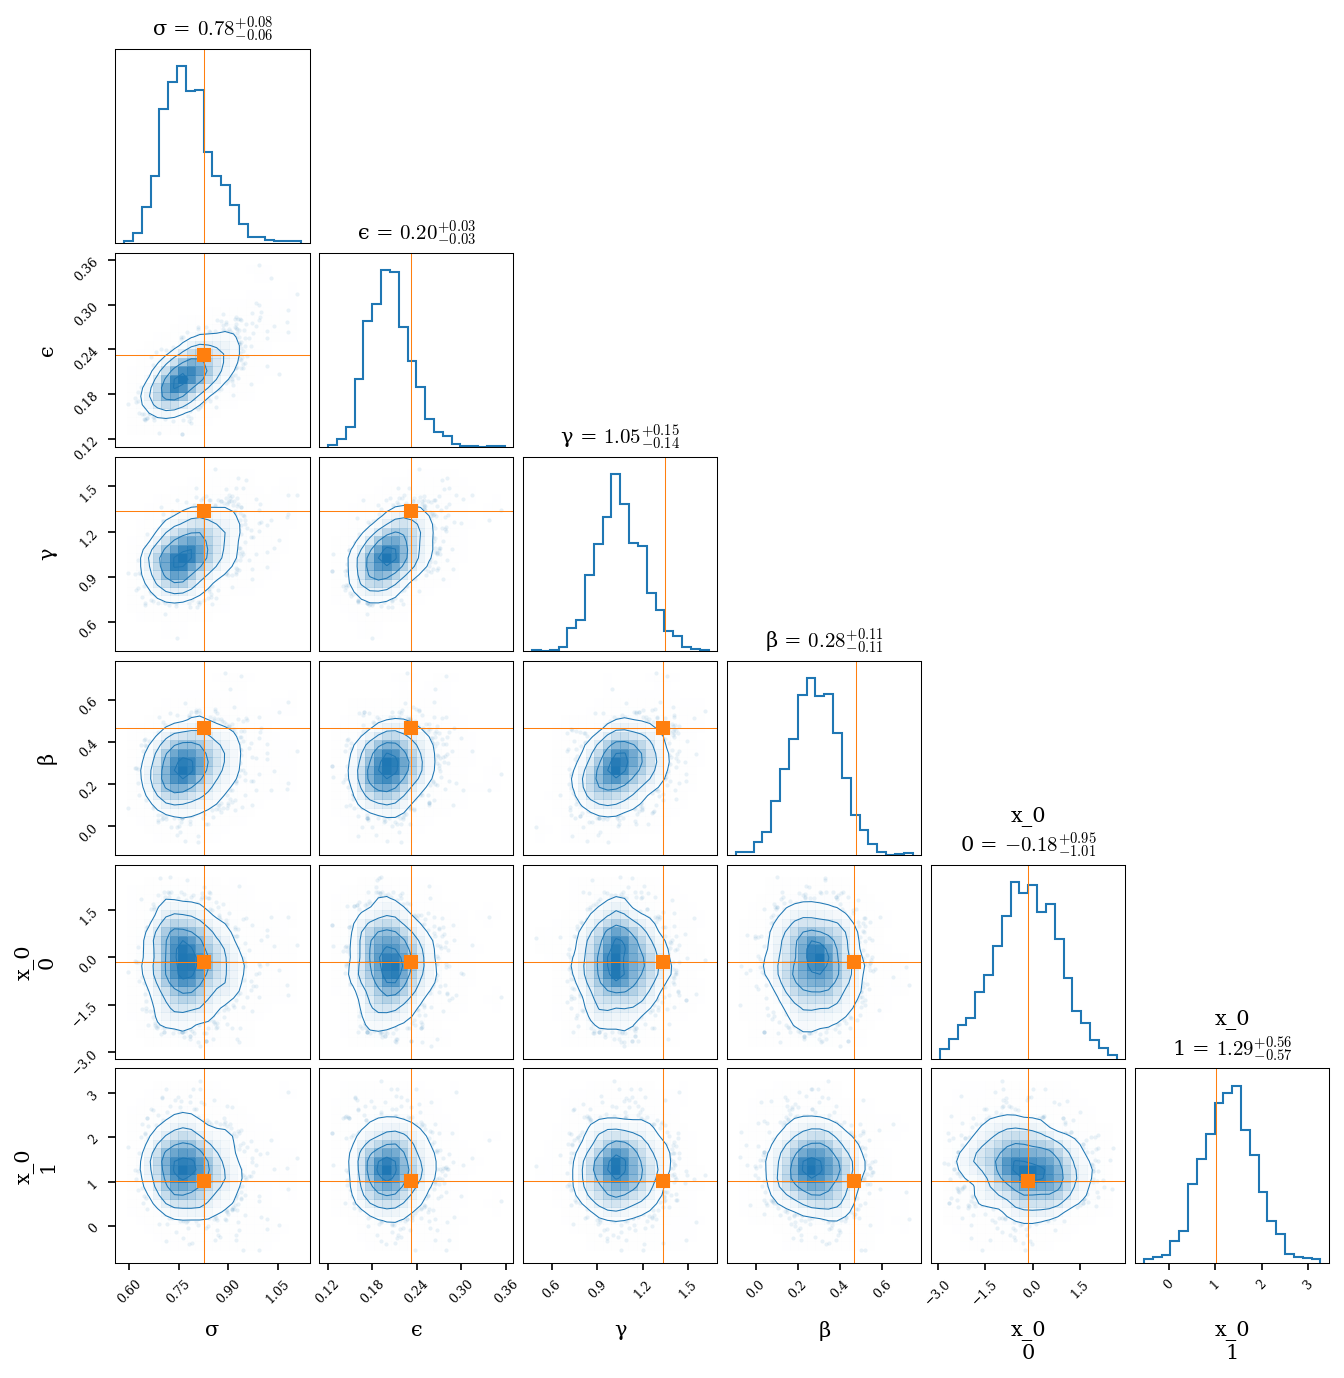

In [23]:
num_var = dim_z + dim_x
with plt.style.context(plot_style):
    fig, axes = plt.subplots(num_var, num_var, figsize=(1.5 * num_var, 1.5 * num_var))
    _ = corner.corner(
        traces,
        var_names=["σ", "ϵ", "γ", "β", "x_0"],
        truths=list(z_ref) + list(x_0_ref),
        color="C0",
        truth_color="C1",
        show_titles=True,
        smooth=1.0,
        fig=fig,
    )
    for i in range(num_var):
        for j in range(i + 1):
            if i != num_var - 1:
                axes[i, j].xaxis.set_ticks_position("none")
            if j != 0 or (i == j == 0):
                axes[i, j].yaxis.set_ticks_position("none")

We can also plot estimated pairwise posterior marginals for a subset of the latent noise vectors $\mathsf{v}_{1{:}\mathtt{ST}}$ from which we see that they remain close in distribution to their independent standard normal priors.

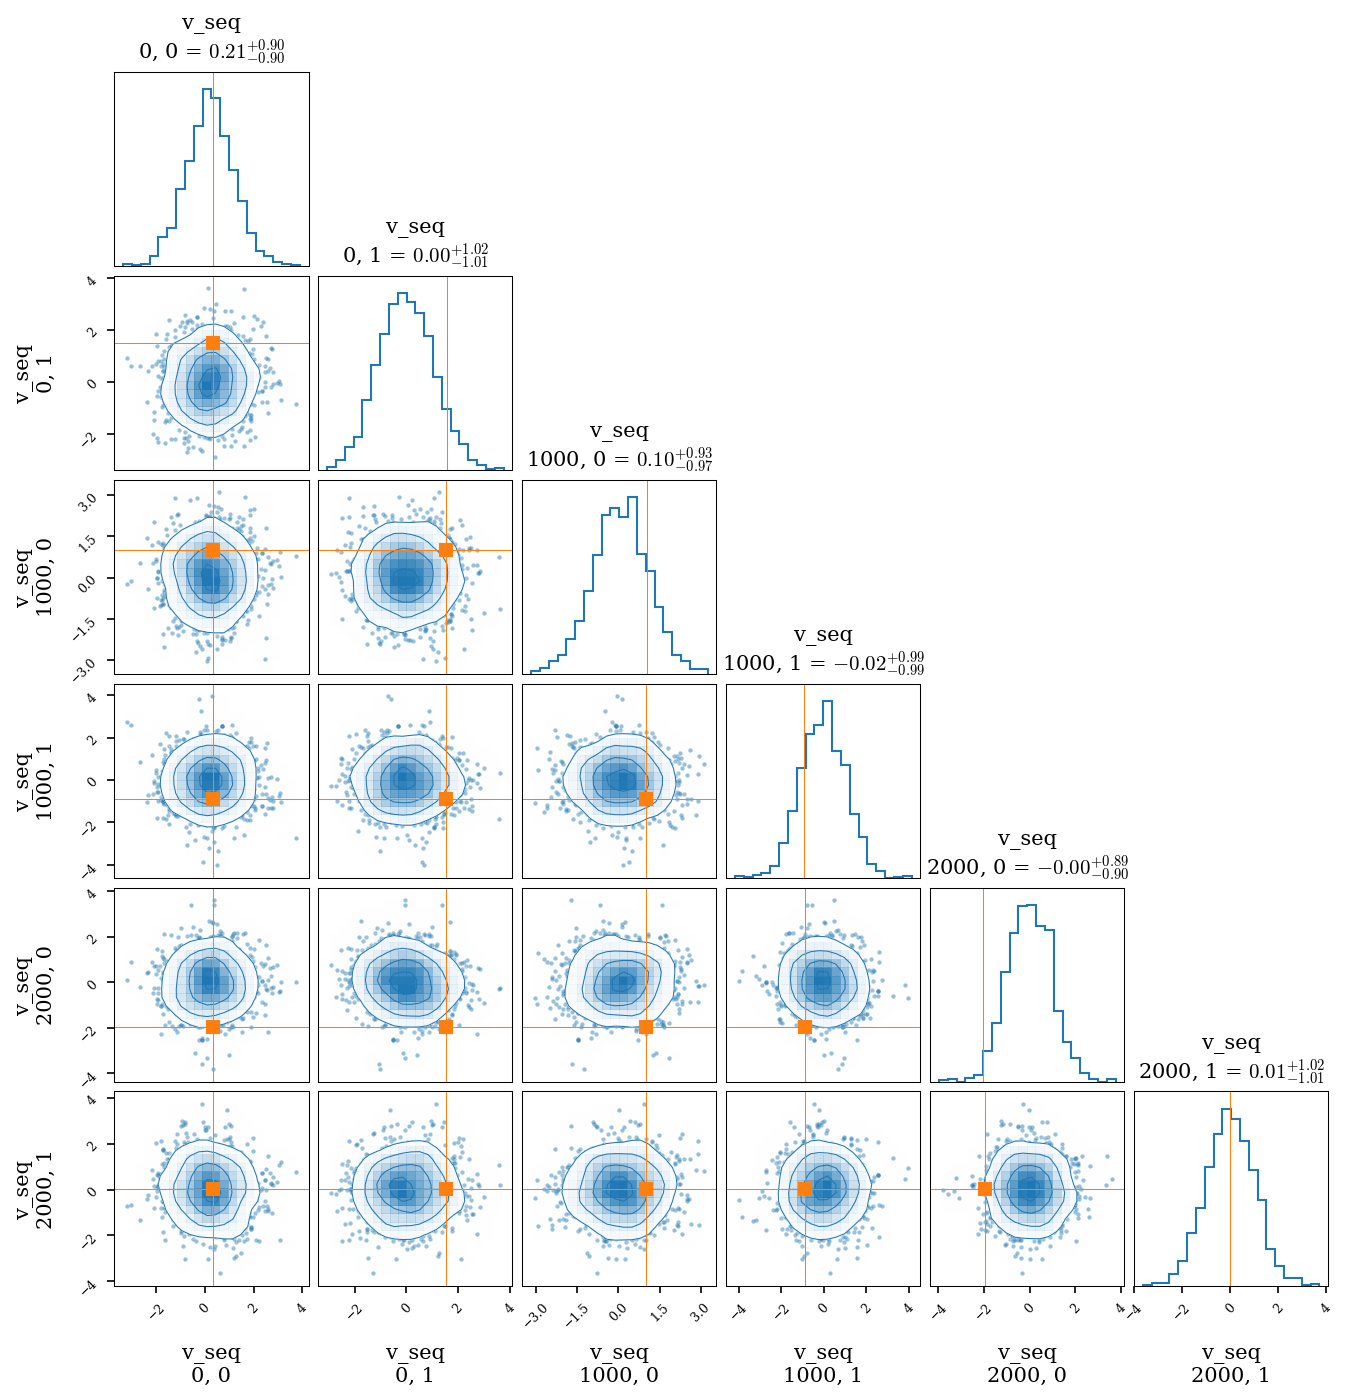

In [24]:
plot_indices = [(0, 0), (0, 1), (1000, 0), (1000, 1), (2000, 0), (2000, 1)]
num_indices = len(plot_indices)
v_seq_ref = q_ref[dim_x + dim_x :].reshape((-1, dim_v))
with plt.style.context(plot_style):
    fig, axes = plt.subplots(
        num_indices, num_indices, figsize=(1.5 * num_indices, 1.5 * num_indices)
    )
    _ = corner.corner(
        traces,
        var_names=["v_seq"],
        coords={
            "v_seq_dim_0": [i[0] for i in plot_indices],
            "v_seq_dim_1": [i[1] for i in plot_indices],
        },
        truths=[v_seq_ref[i] for i in plot_indices],
        color="C0",
        truth_color="C1",
        show_titles=True,
        smooth=1.0,
        fig=fig,
    )
    for i in range(num_indices):
        for j in range(i + 1):
            if i != num_var - 1:
                axes[i, j].xaxis.set_ticks_position("none")
            if j != 0 or (i == j == 0):
                axes[i, j].yaxis.set_ticks_position("none")

Trace plots of the parameters and initial state suggest both chains converged to stationarity within the warm up stage.

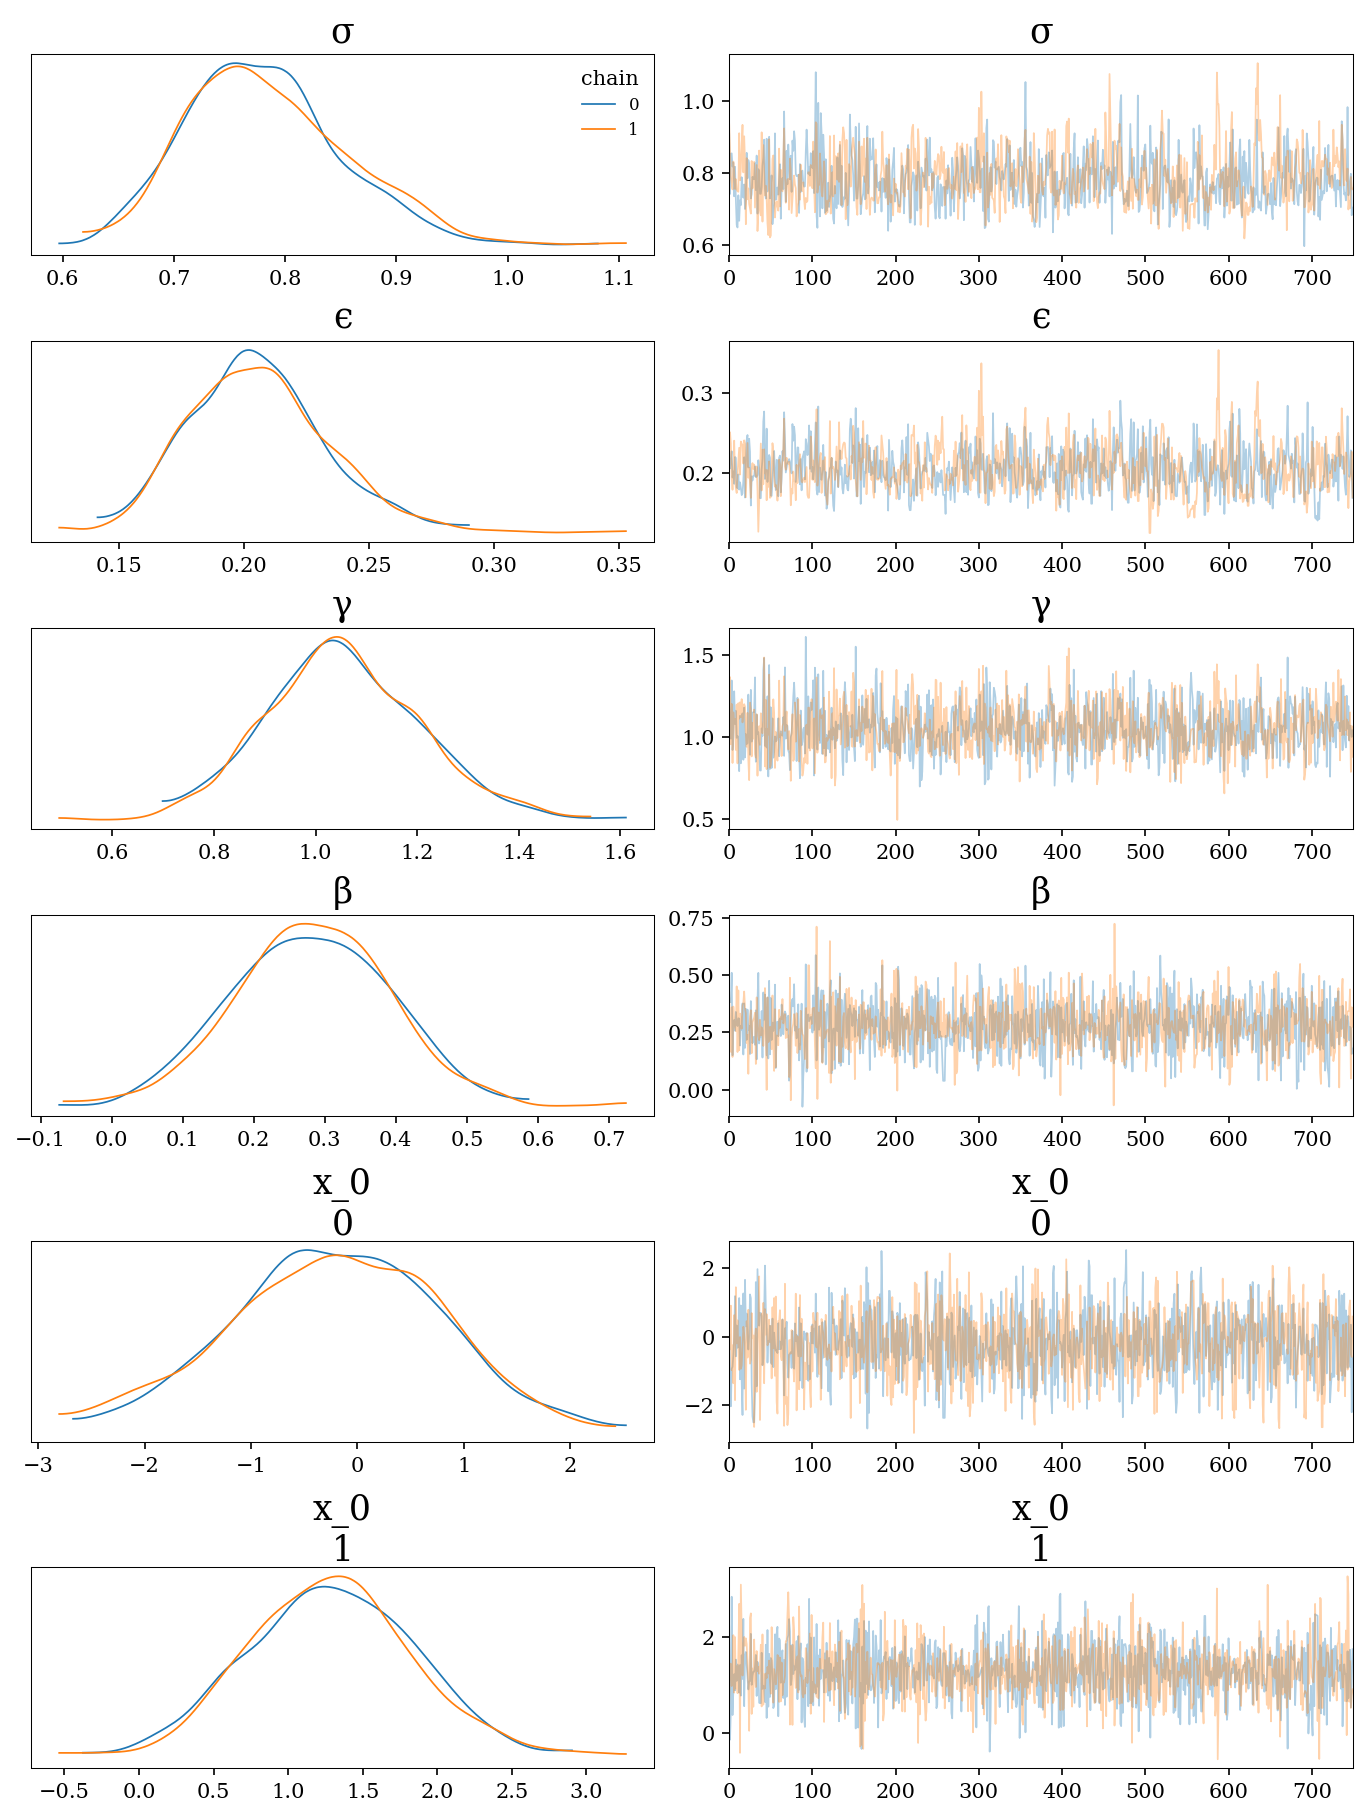

In [25]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces,
        var_names=["σ", "ϵ", "γ", "β", "x_0"],
        figsize=(9, 2 * (dim_x + dim_z)),
        legend=True,
        compact=False,
    )